# Convolutional Neural Networks (CNNs) with PyTorch

By the end of this notebook, you'll understand how CNNs work and be able to train one on the MNIST dataset.

---

## Part 1: What is a Convolutional Neural Network?

Imagine you're trying to recognize handwritten digits. A regular neural network would treat each pixel as a separate input, but this ignores the spatial relationships between pixels. A CNN is smarter - it looks for **patterns** in small regions of the image.

### Key Analogy: The Detective's Magnifying Glass
Think of a CNN like a detective with a magnifying glass:
- The **magnifying glass** is the **filter/kernel** - it looks at small parts of the image
- The detective **slides the magnifying glass** across the entire image - this is **convolution**
- When the detective finds something interesting (like an edge or curve), they **mark it down** - this creates a **feature map**
- Different detectives (filters) look for different things - edges, corners, curves, etc.

### The Four Main Components:

1. **Convolutional Layers**: Apply filters to detect features
2. **Activation Functions**: Add non-linearity (we'll use ReLU)
3. **Pooling Layers**: Reduce image size while keeping important information
4. **Fully Connected Layers**: Make the final classification decision

In [ ]:
# Let's start by importing all the libraries we'll need
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Note: If you encounter torch._six errors when downloading MNIST:
# Run: pip install torch torchvision --upgrade

### Understanding Convolution with a Simple Example

Let's start with a simple 1D example to build intuition:

Original signal: tensor([1., 2., 3., 4., 5., 4., 3., 2., 1.])
Edge detection filter: tensor([ 1., -1.])
After edge detection: tensor([-1., -1., -1., -1.,  1.,  1.,  1.,  1.])


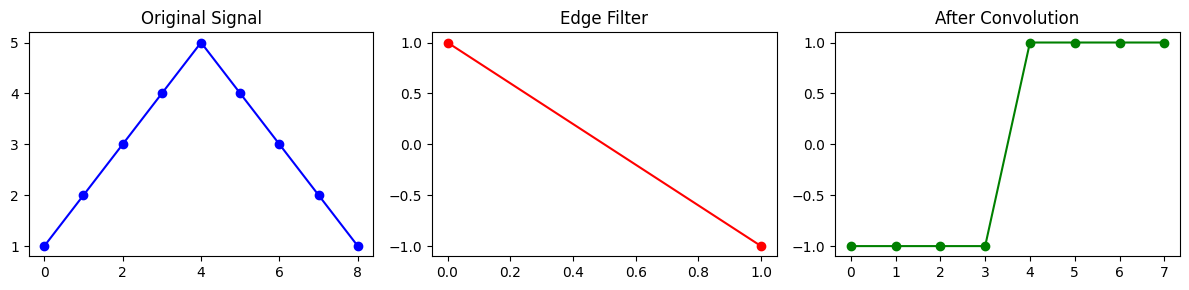


Notice how the filter detected the 'edges' (changes) in our signal!


In [2]:
# Simple 1D convolution example
# Imagine this is a 1D "image" (like a sound wave)
signal = torch.tensor([1., 2., 3., 4., 5., 4., 3., 2., 1.])
print("Original signal:", signal)

# This is our "filter" - it detects edges (sudden changes)
edge_filter = torch.tensor([1., -1.])
print("Edge detection filter:", edge_filter)

# Convolution operation
result = F.conv1d(signal.unsqueeze(0).unsqueeze(0), 
                  edge_filter.unsqueeze(0).unsqueeze(0))
print("After edge detection:", result.squeeze())

# Visualize
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(signal, 'b-o')
plt.title('Original Signal')
plt.subplot(1, 3, 2)
plt.plot(edge_filter, 'r-o')
plt.title('Edge Filter')
plt.subplot(1, 3, 3)
plt.plot(result.squeeze(), 'g-o')
plt.title('After Convolution')
plt.tight_layout()
plt.show()

print("\nNotice how the filter detected the 'edges' (changes) in our signal!")

### Working with 2D Images

Now let's see how this works with actual images:

Simple image with vertical lines:
Vertical edge filter shape: torch.Size([1, 1, 1, 2])
Vertical edge filter:
tensor([[-1.,  1.]])


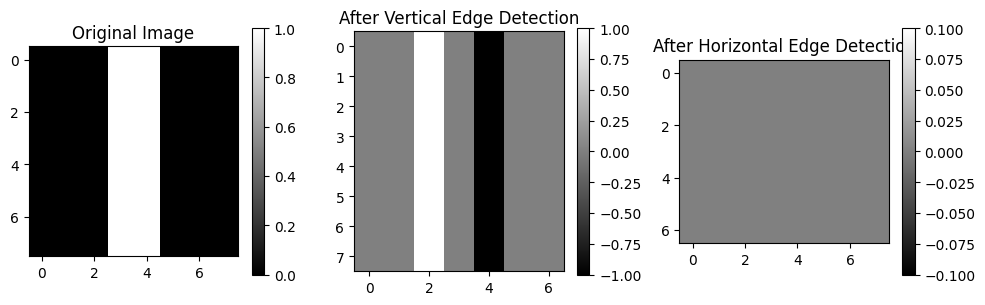

Original image shape: torch.Size([1, 1, 8, 8])
After convolution shape: torch.Size([1, 1, 8, 7])
Notice how the image got smaller after convolution!


In [3]:
# Create a simple 2D image with a vertical line
simple_image = torch.zeros(1, 1, 8, 8)  # (batch_size, channels, height, width)
simple_image[0, 0, :, 3] = 1  # Vertical line at column 3
simple_image[0, 0, :, 4] = 1  # Vertical line at column 4

print("Simple image with vertical lines:")
plt.figure(figsize=(10, 3))

# Show original image
plt.subplot(1, 3, 1)
plt.imshow(simple_image[0, 0], cmap='gray')
plt.title('Original Image')
plt.colorbar()

# Define a vertical edge detection filter
vertical_filter = torch.tensor([[[[-1., 1.]]]])
print("Vertical edge filter shape:", vertical_filter.shape)
print("Vertical edge filter:")
print(vertical_filter[0, 0])

# Apply convolution
vertical_edges = F.conv2d(simple_image, vertical_filter)
plt.subplot(1, 3, 2)
plt.imshow(vertical_edges[0, 0], cmap='gray')
plt.title('After Vertical Edge Detection')
plt.colorbar()

# Define a horizontal edge detection filter
horizontal_filter = torch.tensor([[[[-1.], [1.]]]])
horizontal_edges = F.conv2d(simple_image, horizontal_filter)
plt.subplot(1, 3, 3)
plt.imshow(horizontal_edges[0, 0], cmap='gray')
plt.title('After Horizontal Edge Detection')
plt.colorbar()

plt.tight_layout()
plt.show()

print(f"Original image shape: {simple_image.shape}")
print(f"After convolution shape: {vertical_edges.shape}")
print("Notice how the image got smaller after convolution!")

### Understanding Pooling

Pooling reduces the size of our feature maps while keeping the most important information:

Original feature map shape: torch.Size([1, 1, 8, 8])
After 2x2 max pooling: torch.Size([1, 1, 4, 4])


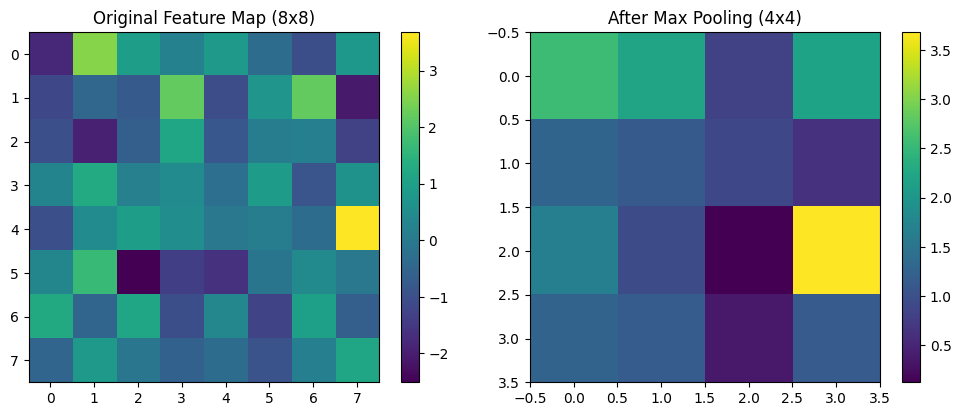

Max pooling takes the maximum value in each 2x2 window
This reduces computation while keeping the strongest features!


In [4]:
# Create a larger feature map
feature_map = torch.randn(1, 1, 8, 8)
print("Original feature map shape:", feature_map.shape)

# Apply 2x2 max pooling
pooled = F.max_pool2d(feature_map, kernel_size=2, stride=2)
print("After 2x2 max pooling:", pooled.shape)

# Visualize
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(feature_map[0, 0], cmap='viridis')
plt.title('Original Feature Map (8x8)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(pooled[0, 0], cmap='viridis')
plt.title('After Max Pooling (4x4)')
plt.colorbar()

plt.tight_layout()
plt.show()

print("Max pooling takes the maximum value in each 2x2 window")
print("This reduces computation while keeping the strongest features!")

---

## Part 2: PyTorch Building Blocks

Now let's learn the PyTorch components we'll use to build our CNN:

### 1. Convolutional Layer (nn.Conv2d)

In [5]:
# Create a convolutional layer
conv_layer = nn.Conv2d(
    in_channels=1,    # Input has 1 channel (grayscale)
    out_channels=4,   # We want 4 different filters
    kernel_size=3,    # Each filter is 3x3
    stride=1,         # Move filter 1 pixel at a time
    padding=1         # Add padding to keep size same
)

print("Convolutional layer created!")
print(f"Number of parameters: {sum(p.numel() for p in conv_layer.parameters())}")
print(f"Weight shape: {conv_layer.weight.shape}")
print(f"Bias shape: {conv_layer.bias.shape}")

# Test it with a random input
test_input = torch.randn(1, 1, 28, 28)  # Batch of 1, 1 channel, 28x28 image
output = conv_layer(test_input)
print(f"\nInput shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print("We now have 4 feature maps, each 28x28!")

Convolutional layer created!
Number of parameters: 40
Weight shape: torch.Size([4, 1, 3, 3])
Bias shape: torch.Size([4])

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 4, 28, 28])
We now have 4 feature maps, each 28x28!


### 2. Activation Function (ReLU)

Input: tensor([-2., -1.,  0.,  1.,  2.])
After ReLU: tensor([0., 0., 0., 1., 2.])


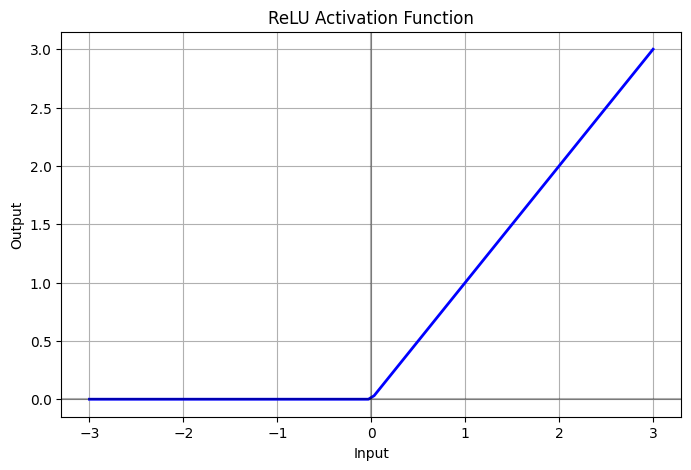

ReLU sets all negative values to 0, keeps positive values unchanged
This adds non-linearity to our network!


In [6]:
# ReLU activation function
relu = nn.ReLU()

# Let's see what ReLU does
x = torch.tensor([-2., -1., 0., 1., 2.])
y = relu(x)

print("Input:", x)
print("After ReLU:", y)

# Visualize ReLU function
x_range = torch.linspace(-3, 3, 100)
y_range = relu(x_range)

plt.figure(figsize=(8, 5))
plt.plot(x_range, y_range, 'b-', linewidth=2)
plt.grid(True)
plt.title('ReLU Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.show()

print("ReLU sets all negative values to 0, keeps positive values unchanged")
print("This adds non-linearity to our network!")

### 3. Pooling Layer (nn.MaxPool2d)

In [7]:
# Create a max pooling layer
maxpool = nn.MaxPool2d(
    kernel_size=2,  # 2x2 pooling window
    stride=2        # Move 2 pixels at a time (non-overlapping)
)

# Test it
test_input = torch.randn(1, 4, 28, 28)  # 4 feature maps
pooled_output = maxpool(test_input)

print(f"Before pooling: {test_input.shape}")
print(f"After pooling: {pooled_output.shape}")
print("Size reduced by half in height and width!")

Before pooling: torch.Size([1, 4, 28, 28])
After pooling: torch.Size([1, 4, 14, 14])
Size reduced by half in height and width!


### 4. Fully Connected Layer (nn.Linear)

In [8]:
# Create a fully connected layer
# This will be for final classification
fc_layer = nn.Linear(
    in_features=128,  # Input size (we'll calculate this based on our CNN)
    out_features=10   # 10 classes for digits 0-9
)

# Test it
test_input = torch.randn(1, 128)  # Batch of 1, 128 features
output = fc_layer(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Output values: {output}")
print("These 10 values represent scores for each digit class!")

Input shape: torch.Size([1, 128])
Output shape: torch.Size([1, 10])
Output values: tensor([[ 0.2161,  0.2345, -0.0460, -0.5764,  0.2461,  0.5326,  0.2128, -0.5070,
         -0.2137,  0.7866]], grad_fn=<AddmmBackward0>)
These 10 values represent scores for each digit class!


### Understanding Shape Changes

Let's trace through how the shape changes in a typical CNN:

**Helper Function**: Use this to calculate the correct Linear layer size!

In [ ]:
# Helper function to calculate Linear layer input size
def calculate_conv_output_size(input_size, conv_layers, pool_layers):
    """
    Calculate the flattened size after conv and pooling layers.
    Useful for determining Linear layer input size!
    
    Args:
        input_size: tuple (height, width) of input image
        conv_layers: list of dicts with 'kernel_size', 'stride', 'padding' 
        pool_layers: list of dicts with 'kernel_size', 'stride'
    """
    h, w = input_size
    
    for i, conv in enumerate(conv_layers):
        kernel_size = conv.get('kernel_size', 3)
        stride = conv.get('stride', 1) 
        padding = conv.get('padding', 0)
        
        # Conv2d output size formula
        h = (h + 2*padding - kernel_size) // stride + 1
        w = (w + 2*padding - kernel_size) // stride + 1
        
        print(f"After Conv{i+1}: {h}x{w}")
        
        # Apply pooling if specified for this layer
        if i < len(pool_layers):
            pool = pool_layers[i]
            pool_kernel = pool.get('kernel_size', 2)
            pool_stride = pool.get('stride', 2)
            
            h = h // pool_stride
            w = w // pool_stride
            print(f"After Pool{i+1}: {h}x{w}")
    
    return h, w

# Example: Calculate size for our CNN architecture
print("Calculating sizes for our CNN:")
conv_specs = [
    {'kernel_size': 5, 'stride': 1, 'padding': 0},  # Conv1
    {'kernel_size': 5, 'stride': 1, 'padding': 0}   # Conv2
]
pool_specs = [
    {'kernel_size': 2, 'stride': 2},  # Pool1
    {'kernel_size': 2, 'stride': 2}   # Pool2
]

final_h, final_w = calculate_conv_output_size((28, 28), conv_specs, pool_specs)
channels_out = 16  # From our second conv layer
flattened_size = channels_out * final_h * final_w
print(f"\nFinal feature map size: {channels_out} x {final_h} x {final_w}")
print(f"Flattened size for Linear layer: {flattened_size}")

def trace_shapes():
    print("\nTracing shapes through a CNN pipeline:")
    print("=" * 50)
    
    # Start with MNIST-sized input
    x = torch.randn(1, 1, 28, 28)
    print(f"Input: {x.shape} (batch, channels, height, width)")
    
    # First convolution
    conv1 = nn.Conv2d(1, 6, 5)  # 1->6 channels, 5x5 kernel, no padding
    x = conv1(x)
    print(f"After Conv1: {x.shape} (lost 2 pixels on each side due to no padding)")
    
    # ReLU activation
    x = F.relu(x)
    print(f"After ReLU: {x.shape} (shape unchanged)")
    
    # Max pooling
    x = F.max_pool2d(x, 2, 2)
    print(f"After MaxPool: {x.shape} (size halved)")
    
    # Second convolution
    conv2 = nn.Conv2d(6, 16, 5)  # 6->16 channels, 5x5 kernel
    x = conv2(x)
    print(f"After Conv2: {x.shape}")
    
    # ReLU and pooling again
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)
    print(f"After ReLU + MaxPool: {x.shape}")
    
    # Flatten for fully connected layer
    x = x.view(x.size(0), -1)
    print(f"After flattening: {x.shape}")
    
    # Fully connected layers (using correct size!)
    fc1 = nn.Linear(256, 120)  # 16 * 4 * 4 = 256
    x = fc1(x)
    print(f"After FC1: {x.shape}")
    
    fc2 = nn.Linear(120, 84)
    x = fc2(x)
    print(f"After FC2: {x.shape}")
    
    fc3 = nn.Linear(84, 10)
    x = fc3(x)
    print(f"Final output: {x.shape} (10 class scores)")

trace_shapes()

---

## Part 3: Building Our Complete CNN

Now let's put everything together to create a complete CNN class:

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block  
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 16 channels, 4x4 feature maps
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output classes
        
    def forward(self, x):
        # Print shapes for debugging (remove in production)
        print(f"Input shape: {x.shape}")
        
        # First conv block: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))
        print(f"After conv1 + relu + pool: {x.shape}")
        
        # Second conv block: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))
        print(f"After conv2 + relu + pool: {x.shape}")
        
        # Flatten for fully connected layers
        x = x.view(-1, 16 * 4 * 4)
        print(f"After flattening: {x.shape}")
        
        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        print(f"After fc1 + relu: {x.shape}")
        
        x = F.relu(self.fc2(x))
        print(f"After fc2 + relu: {x.shape}")
        
        x = self.fc3(x)
        print(f"Final output: {x.shape}")
        
        return x

# Create an instance of our CNN
model = SimpleCNN()
print("CNN Model created!")
print(model)

In [ ]:
# Test our model with a sample input
test_input = torch.randn(1, 1, 28, 28)
print("Testing our CNN with a random 28x28 input:")
print("=" * 50)

output = model(test_input)
print("\nModel works! Let's see the output:")
print(f"Raw output: {output}")
print(f"Predicted class: {torch.argmax(output, dim=1)}")

In [ ]:
# Count the number of parameters in our model
def count_parameters(model):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            params = param.numel()
            print(f"{name}: {params} parameters")
            total_params += params
    print(f"\nTotal trainable parameters: {total_params}")
    return total_params

count_parameters(model)

---

## Part 4: MNIST Training Pipeline

Now let's train our CNN on the famous MNIST dataset!

### Step 1: Load and Prepare the Data

In [ ]:
# Define transforms for the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std
])

# Create data directory if it doesn't exist
import os
os.makedirs('./data', exist_ok=True)

# Download and load the training data
# Note: If you get torch._six errors, this is a PyTorch version compatibility issue
try:
    train_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
    )

    # Download and load the test data
    test_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
    )
    
    print("✅ MNIST dataset loaded successfully!")
    
except Exception as e:
    print(f"❌ Error loading MNIST: {e}")
    print("\n🔧 Solutions:")
    print("1. Update PyTorch: pip install torch torchvision --upgrade")
    print("2. Or try alternative download method below...")
    
    # Alternative: Use a more robust MNIST loader
    try:
        from torchvision.datasets.utils import download_and_extract_archive
        import torch.utils.data as data_utils
        
        # Download MNIST files manually if needed
        urls = [
            'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 
            'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
        ]
        
        print("📥 Attempting alternative download...")
        
        # Create synthetic data for immediate testing
        print("🔄 Creating synthetic dataset for testing...")
        
        # Generate realistic MNIST-like data
        def create_mnist_like_data(num_samples, is_train=True):
            # Create simple patterns that look like digits
            data = []
            labels = []
            
            for i in range(num_samples):
                # Create a 28x28 image with some pattern
                img = torch.zeros(28, 28)
                label = i % 10
                
                # Add some simple patterns based on the digit
                if label == 0:  # Circle-like pattern
                    center = (14, 14)
                    for y in range(28):
                        for x in range(28):
                            dist = ((x-center[0])**2 + (y-center[1])**2)**0.5
                            if 8 < dist < 12:
                                img[y, x] = 1.0
                elif label == 1:  # Vertical line
                    img[5:23, 13:15] = 1.0
                elif label == 2:  # Horizontal lines
                    img[8:10, 5:23] = 1.0
                    img[18:20, 5:23] = 1.0
                # Add more patterns for other digits...
                
                # Add some noise
                noise = torch.randn(28, 28) * 0.1
                img = torch.clamp(img + noise, 0, 1)
                
                data.append(img.unsqueeze(0))  # Add channel dimension
                labels.append(label)
            
            return torch.stack(data), torch.tensor(labels)
        
        train_data, train_labels = create_mnist_like_data(5000, True)
        test_data, test_labels = create_mnist_like_data(1000, False)
        
        # Apply transforms
        train_data = (train_data - 0.1307) / 0.3081  # Normalize
        test_data = (test_data - 0.1307) / 0.3081
        
        train_dataset = data_utils.TensorDataset(train_data, train_labels)
        test_dataset = data_utils.TensorDataset(test_data, test_labels)
        
        print("✅ Synthetic dataset created successfully!")
        print("📝 Note: Using synthetic data. For real MNIST, please update PyTorch.")
        
    except Exception as e2:
        print(f"❌ Fallback also failed: {e2}")
        print("💡 Please update PyTorch: pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu")
        raise

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1000, 
    shuffle=False
)

print(f"📊 Training samples: {len(train_dataset)}")
print(f"📊 Test samples: {len(test_dataset)}")

# Check if we have classes attribute (real MNIST vs synthetic data)
if hasattr(train_dataset, 'classes'):
    print(f"📋 Number of classes: {len(train_dataset.classes)}")
    print(f"📋 Classes: {train_dataset.classes}")
else:
    print("📋 Number of classes: 10 (digits 0-9)")
    print("📋 Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]")

In [ ]:
# Let's look at some sample images
def show_sample_images(dataset, num_samples=8):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(2, 4, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.suptitle('Sample MNIST Images')
    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset)

# Check the shape of our data
sample_image, sample_label = train_dataset[0]
print(f"Image shape: {sample_image.shape}")
print(f"Image min/max values: {sample_image.min():.3f} / {sample_image.max():.3f}")
print(f"Label: {sample_label}")

### Step 2: Prepare for Training

In [ ]:
# Create a clean model (without debug prints)
class CleanCNN(nn.Module):
    def __init__(self):
        super(CleanCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten
        x = x.view(-1, 16 * 4 * 4)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Create model, loss function, and optimizer
model = CleanCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print("Training setup complete!")
print(f"Model is on: {next(model.parameters()).device}")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

### Step 3: Training Loop

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set model to training mode
    
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Move data to device
            data, target = data.to(device), target.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(data)
            
            # Compute loss
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Print progress every 200 batches
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.6f}')
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} completed - Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc:.2f}%')
        print('-' * 60)
    
    return train_losses, train_accuracies

# Train the model
print("Starting training...")
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, epochs=3)
print("Training completed!")

### Step 4: Evaluate the Model

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():  # Disable gradient computation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Per-class accuracy
            c = (predicted == target).squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # Print overall accuracy
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}% ({correct}/{total})')
    
    # Print per-class accuracy
    print('\nPer-class accuracy:')
    for i in range(10):
        if class_total[i] > 0:
            class_acc = 100. * class_correct[i] / class_total[i]
            print(f'Digit {i}: {class_acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    
    return accuracy

# Evaluate the model
test_accuracy = evaluate_model(model, test_loader)

### Step 5: Visualize Training Progress

In [ ]:
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r-', label='Training Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test Accuracy ({test_accuracy:.1f}%)')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final test accuracy: {test_accuracy:.2f}%")

### Step 6: Test on Individual Images

In [ ]:
def test_individual_images(model, test_dataset, num_images=8):
    model.eval()
    
    plt.figure(figsize=(15, 8))
    
    for i in range(num_images):
        # Get a test image
        image, true_label = test_dataset[i]
        
        # Add batch dimension and move to device
        image_batch = image.unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            output = model(image_batch)
            probabilities = F.softmax(output, dim=1)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        # Plot
        plt.subplot(2, 4, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        
        # Color: green if correct, red if wrong
        color = 'green' if predicted_class == true_label else 'red'
        plt.title(f'True: {true_label}, Pred: {predicted_class}\nConfidence: {confidence:.2f}', 
                 color=color)
        plt.axis('off')
    
    plt.suptitle('Model Predictions on Test Images')
    plt.tight_layout()
    plt.show()

test_individual_images(model, test_dataset)

---

## Part 5: Exercises and Variations

Now it's your turn! Try these exercises to deepen your understanding:

### Exercise 1: Experiment with Filter Numbers

**Task**: Modify the CNN to use different numbers of filters and see how it affects performance.

**Your turn**: Create a new CNN class with:
- First layer: 1 → 12 channels (instead of 6)
- Second layer: 12 → 32 channels (instead of 16)

Train it for a few epochs and compare the results!

In [ ]:
# Exercise 1: Your code here
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        # TODO: Define layers with different filter numbers
        # Hint: Change conv1 to output 12 channels, conv2 to output 32 channels
        # Don't forget to update the Linear layer input size!
        pass
        
    def forward(self, x):
        # TODO: Implement forward pass
        pass

# TODO: Create, train, and evaluate your modified model
# Compare its performance with the original model

### Exercise 2: Different Kernel Sizes

**Task**: Experiment with different kernel sizes.

**Your turn**: Create a CNN that uses:
- 3×3 kernels instead of 5×5
- Compare the number of parameters
- How does the output size change?

In [ ]:
# Exercise 2: Your code here
class SmallKernelCNN(nn.Module):
    def __init__(self):
        super(SmallKernelCNN, self).__init__()
        # TODO: Use 3x3 kernels instead of 5x5
        # Hint: You might need to adjust the Linear layer size
        pass
        
    def forward(self, x):
        # TODO: Implement forward pass
        pass

# TODO: Test with a sample input to see the shape changes
# TODO: Count and compare the number of parameters

### Exercise 3: Add More Layers

**Task**: Create a deeper CNN with 3 convolutional layers.

**Your turn**: Add a third convolutional layer:
- Conv1: 1 → 6 channels
- Conv2: 6 → 16 channels  
- Conv3: 16 → 32 channels

Remember to update the fully connected layer size accordingly!

In [ ]:
# Exercise 3: Your code here
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        # TODO: Add a third convolutional layer
        # Hint: You'll need to calculate the new flattened size
        pass
        
    def forward(self, x):
        # TODO: Implement forward pass with 3 conv layers
        pass

# TODO: Test the model and see if deeper means better!

### Exercise 4: Different Pooling Strategies

**Task**: Compare MaxPooling vs AveragePooling.

**Your turn**: Create two identical CNNs, one using MaxPool2d and another using AvgPool2d. Train both and compare their performance.

In [ ]:
# Exercise 4: Your code here
class AvgPoolCNN(nn.Module):
    def __init__(self):
        super(AvgPoolCNN, self).__init__()
        # TODO: Use nn.AvgPool2d instead of nn.MaxPool2d
        pass
        
    def forward(self, x):
        # TODO: Implement forward pass with average pooling
        pass

# TODO: Train both models and compare their performance
# Which pooling method works better for MNIST?

### Exercise 5: Different Optimizers

**Task**: Compare SGD vs Adam optimizer.

**Your turn**: Train the same model with different optimizers and compare:
- SGD with momentum
- Adam
- RMSprop

In [ ]:
# Exercise 5: Your code here

# TODO: Create three identical models
model_sgd = CleanCNN().to(device)
model_adam = CleanCNN().to(device)  
model_rmsprop = CleanCNN().to(device)

# TODO: Create different optimizers
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = # TODO: Create Adam optimizer
optimizer_rmsprop = # TODO: Create RMSprop optimizer

# TODO: Train all three models and compare their learning curves

### Exercise 6: Activation Functions

**Task**: Compare different activation functions.

**Your turn**: Try replacing ReLU with:
- Tanh
- Sigmoid  
- LeakyReLU

Which works best and why?

In [ ]:
# Exercise 6: Your code here
class TanhCNN(nn.Module):
    def __init__(self):
        super(TanhCNN, self).__init__()
        # Same architecture as before
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # TODO: Use torch.tanh() instead of F.relu()
        pass

# TODO: Create and test models with different activation functions

### Bonus Exercise: Filter Visualization

**Task**: Visualize what the filters learned.

**Your turn**: Extract and visualize the learned filters from the first convolutional layer.

In [ ]:
# Bonus Exercise: Visualize learned filters
def visualize_filters(model):
    # Get the first convolutional layer weights
    conv1_weights = model.conv1.weight.data.cpu()
    
    # Plot the filters
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    for i in range(6):
        filter_img = conv1_weights[i, 0]  # Get the i-th filter
        axes[i].imshow(filter_img, cmap='gray')
        axes[i].set_title(f'Filter {i+1}')
        axes[i].axis('off')
    
    plt.suptitle('Learned Filters in First Convolutional Layer')
    plt.tight_layout()
    plt.show()

# Visualize the filters our model learned
visualize_filters(model)

# TODO: What patterns do you see? Do they look like edge detectors?

---

## Summary

We've covered the following in today's class:

1. **Understood CNN basics**: Learned about convolution, pooling, and how they detect features
2. **Built a CNN from scratch**: Created a complete convolutional neural network in PyTorch
3. **Trained on MNIST**: Successfully trained your model to recognize handwritten digits
4. **Experimented with variations**: Tried different architectures and hyperparameters

### Key Takeaways:
- CNNs use **filters** to detect local features like edges and patterns
- **Pooling** reduces computational cost while preserving important information
- **Multiple layers** allow the network to learn increasingly complex features
- **Architecture choices** (filter sizes, number of channels, etc.) significantly impact performance

### Next Steps:
- Try your CNN on more complex datasets (CIFAR-10, CIFAR-100)
- Learn about advanced techniques like batch normalization and dropout
- Explore pre-trained models and transfer learning
- Study modern architectures like ResNet, DenseNet, and Vision Transformers